In [1]:
# Initiation date: 14/07/2024
# Authors: Abdul (Shadab)
# Summary: This code has functions written that fetch data from GSheet, store it in raw data file if needed, process and tranform
#          the raw DataFrame, and store it in a final output sheet if needed.
#          This code also runs various statistical calculations and creates visualisations to study trends and patterns
#Project: Khan Academy M&E insights analyst

In [2]:
import pandas as pd
import numpy as np
import requests
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import time
import datetime
from zoneinfo import ZoneInfo
import os
import io
import re

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
from configparser import ConfigParser

data_file = 'config.txt'

# Initialising the ConfigParser with encoding parameter
config = ConfigParser(strict=False)
config.read(data_file, encoding='utf-8')  # Specifying the encoding

# To access the configuration values using config.get() or similar methods

['config.txt']

In [5]:
#Getting Google Sheet IDs from config
FINAL_OUTPUT_DATA_SHEET = config['GOOGLE_SHEET_UIDS']['FINAL_OUTPUT_DATA_SHEET']

RAW_DATA_SHEET = config['GOOGLE_SHEET_UIDS']['RAW_DATA_SHEET']

In [6]:
#Getting Sheet names from config

#Output sheet name
NUMBER_OF_ACTIVE_STUDENTS_PER_MONTH = config['SHEET_NAMES']['NUMBER_OF_ACTIVE_STUDENTS_PER_MONTH']
AVERAGE_LEARNING_TIME_PER_ACTIVE_STUDENT = config['SHEET_NAMES']['AVERAGE_LEARNING_TIME_PER_ACTIVE_STUDENT']

#Input sheet name
INPUT_DATA_SET = config['SHEET_NAMES']['INPUT_DATA_SET']

In [7]:
#reading credentials for using gspread
gc=gspread.service_account(filename='sheets-api-other-exploration-7bcd2071bcad.json')

## Creatinf a Read and Write Function for google sheets

In [8]:
# Read = reads the data till 500 rows - can be adjusted later if needed

def read_data_from_google_sheet(google_sheet_id, worksheet_title):
    try:
        sh=gc.open_by_key(google_sheet_id)
    
    except Exception as e:
        print("The file with the id "+google_sheet_id+" cant be opened: " + e)
        exit(1)
    
    
    try:
        worksheet = sh.worksheet(worksheet_title)
        gs_df = get_as_dataframe(worksheet, header=0,nrows=500, evaluate_formulas=True).dropna(how='all').dropna(axis=1,how='all')
        return gs_df

    except gspread.WorksheetNotFound:
        print(worksheet_title+" not found")
        exit(1)

# Write
def write_output_data_to_google_sheet(google_sheet_id,worksheet_title,df_input,mode):
    sh=gc.open_by_key(google_sheet_id)

    try:
        worksheet = sh.worksheet(worksheet_title)
    except gspread.WorksheetNotFound:
        worksheet = sh.add_worksheet(title=worksheet_title, rows=500, cols=100)

    if mode=='OVERWRITE':
        set_with_dataframe(worksheet, df_input)

      # Write the DataFrame to the worksheet in append mode
    if mode=='APPEND':
        data_list = df_input.values.tolist()
        worksheet.append_rows(data_list)

In [9]:
# Reading raw data_set to test the function
raw_data = read_data_from_google_sheet(RAW_DATA_SHEET, INPUT_DATA_SET)

# Handling the first 3 columns separately

general_info_df = raw_data[raw_data.columns[0:3]]
general_info_df = general_info_df.drop(0)
general_info_df.reset_index(drop=True, inplace=True)
general_info_df


,District Name,School Name,Total Number of Students Registered
0,District 1,ZPP 1,133.0
1,District 1,ZPP 2,135.0
2,District 1,ZPP 3,69.0
3,District 1,ZPP 4,106.0
4,District 1,ZPP 5,102.0
5,District 1,ZPP 6,175.0
6,District 1,ZPP 7,188.0
7,District 2,ZPP 8,125.0
8,District 2,ZPP 9,169.0
9,District 2,ZPP 10,85.0


In [10]:
# The data starts from the second row, that is, the column headers are in the second row except for the first 3 columns.
#Keeping the School Name columns as it's the only value that can serve as the Primary key (Later when we separate the no. of students and avg. learning time)
raw_data = raw_data.drop(columns=['District Name', 'School Name', 'Total Number of Students Registered'])
raw_data

,Numbers of active students (per month),Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Average learning time on KA per active students (in minutes per month),Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
1,2,0,7,44,37,6,7,0,4,2,1,1,0,0,47.2,57.7,19.1,31.4,0,0,20.8,12.9,15,0
2,5,2,12,59,23,8,13,11,6,12,5,0,3,24.8,30,24.2,18,23.4,34.3,34.5,29.5,23.8,0,0
3,0,0,4,31,32,18,4,6,3,1,0,0,0,0,42.8,73.9,76.5,45.1,29.8,25.1,11,0,0,0
4,5,1,12,9,24,24,23,10,15,9,1,0,4,16.1,29.4,36,43.4,46.1,31.9,31,31.7,42.3,0,0
5,1,0,3,15,26,4,1,3,1,1,0,0,0,0,44.7,35.1,101.4,24,20.3,5,8.4,0,0,0
6,23,3,0,66,1,23,2,0,0,0,0,0,11.1,0,0,5.5,22.4,52.9,0,0,0,0,0,0
7,18,1,3,38,2,33,1,3,6,0,1,0,25.9,21.4,30.7,47,25,7.2,15.3,22.4,0,0,0,0
8,1,6,58,30,25,26,1,1,0,1,0,0,7.4,20.2,8.8,21.8,13,7,1.9,0,0,0,0,0
9,9,4,18,32,44,60,41,22,7,3,3,21,5.5,31.8,41.6,40.6,45.1,17.7,22.9,7.7,2.5,4.7,16.8,4.7


In [11]:
new_header = raw_data.iloc[0]
raw_data_df = raw_data[1:]
raw_data_df.columns = new_header  # Set the new header
raw_data_df

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
1,2,0,7,44,37,6,7,0,4,2,1,1,0,0,47.2,57.7,19.1,31.4,0,0,20.8,12.9,15,0
2,5,2,12,59,23,8,13,11,6,12,5,0,3,24.8,30,24.2,18,23.4,34.3,34.5,29.5,23.8,0,0
3,0,0,4,31,32,18,4,6,3,1,0,0,0,0,42.8,73.9,76.5,45.1,29.8,25.1,11,0,0,0
4,5,1,12,9,24,24,23,10,15,9,1,0,4,16.1,29.4,36,43.4,46.1,31.9,31,31.7,42.3,0,0
5,1,0,3,15,26,4,1,3,1,1,0,0,0,0,44.7,35.1,101.4,24,20.3,5,8.4,0,0,0
6,23,3,0,66,1,23,2,0,0,0,0,0,11.1,0,0,5.5,22.4,52.9,0,0,0,0,0,0
7,18,1,3,38,2,33,1,3,6,0,1,0,25.9,21.4,30.7,47,25,7.2,15.3,22.4,0,0,0,0
8,1,6,58,30,25,26,1,1,0,1,0,0,7.4,20.2,8.8,21.8,13,7,1.9,0,0,0,0,0
9,9,4,18,32,44,60,41,22,7,3,3,21,5.5,31.8,41.6,40.6,45.1,17.7,22.9,7.7,2.5,4.7,16.8,4.7
10,11,2,20,32,29,52,26,2,0,1,3,1,9.6,41.6,14.9,13.5,4.4,6.7,1.5,0,0,14.6,11.1,4.6


In [12]:
#  Merging the two dataframes - using the index as they both spawned from the same dataset
# Resetting the index for the raw_data_df
raw_data_df.reset_index(drop=True, inplace=True)



In [13]:
raw_data_df

,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
0,2,0,7,44,37,6,7,0,4,2,1,1,0,0,47.2,57.7,19.1,31.4,0,0,20.8,12.9,15,0
1,5,2,12,59,23,8,13,11,6,12,5,0,3,24.8,30,24.2,18,23.4,34.3,34.5,29.5,23.8,0,0
2,0,0,4,31,32,18,4,6,3,1,0,0,0,0,42.8,73.9,76.5,45.1,29.8,25.1,11,0,0,0
3,5,1,12,9,24,24,23,10,15,9,1,0,4,16.1,29.4,36,43.4,46.1,31.9,31,31.7,42.3,0,0
4,1,0,3,15,26,4,1,3,1,1,0,0,0,0,44.7,35.1,101.4,24,20.3,5,8.4,0,0,0
5,23,3,0,66,1,23,2,0,0,0,0,0,11.1,0,0,5.5,22.4,52.9,0,0,0,0,0,0
6,18,1,3,38,2,33,1,3,6,0,1,0,25.9,21.4,30.7,47,25,7.2,15.3,22.4,0,0,0,0
7,1,6,58,30,25,26,1,1,0,1,0,0,7.4,20.2,8.8,21.8,13,7,1.9,0,0,0,0,0
8,9,4,18,32,44,60,41,22,7,3,3,21,5.5,31.8,41.6,40.6,45.1,17.7,22.9,7.7,2.5,4.7,16.8,4.7
9,11,2,20,32,29,52,26,2,0,1,3,1,9.6,41.6,14.9,13.5,4.4,6.7,1.5,0,0,14.6,11.1,4.6


In [14]:
final_raw_data_df = pd.merge(general_info_df, raw_data_df, left_index=True, right_index=True)
final_raw_data_df

,District Name,School Name,Total Number of Students Registered,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
0,District 1,ZPP 1,133.0,2,0,7,44,37,6,7,0,4,2,1,1,0,0,47.2,57.7,19.1,31.4,0,0,20.8,12.9,15,0
1,District 1,ZPP 2,135.0,5,2,12,59,23,8,13,11,6,12,5,0,3,24.8,30,24.2,18,23.4,34.3,34.5,29.5,23.8,0,0
2,District 1,ZPP 3,69.0,0,0,4,31,32,18,4,6,3,1,0,0,0,0,42.8,73.9,76.5,45.1,29.8,25.1,11,0,0,0
3,District 1,ZPP 4,106.0,5,1,12,9,24,24,23,10,15,9,1,0,4,16.1,29.4,36,43.4,46.1,31.9,31,31.7,42.3,0,0
4,District 1,ZPP 5,102.0,1,0,3,15,26,4,1,3,1,1,0,0,0,0,44.7,35.1,101.4,24,20.3,5,8.4,0,0,0
5,District 1,ZPP 6,175.0,23,3,0,66,1,23,2,0,0,0,0,0,11.1,0,0,5.5,22.4,52.9,0,0,0,0,0,0
6,District 1,ZPP 7,188.0,18,1,3,38,2,33,1,3,6,0,1,0,25.9,21.4,30.7,47,25,7.2,15.3,22.4,0,0,0,0
7,District 2,ZPP 8,125.0,1,6,58,30,25,26,1,1,0,1,0,0,7.4,20.2,8.8,21.8,13,7,1.9,0,0,0,0,0
8,District 2,ZPP 9,169.0,9,4,18,32,44,60,41,22,7,3,3,21,5.5,31.8,41.6,40.6,45.1,17.7,22.9,7.7,2.5,4.7,16.8,4.7
9,District 2,ZPP 10,85.0,11,2,20,32,29,52,26,2,0,1,3,1,9.6,41.6,14.9,13.5,4.4,6.7,1.5,0,0,14.6,11.1,4.6


In [15]:
# Separating the two datasets --> no.of active students and avg. learning time

# df_number_of_students
columns_df1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
# df_avg_learning_time = 
columns_df2 = [0,1,2,15,16,17,18,19,20,21,22,23,24,25,26]

df_number_of_students = final_raw_data_df.iloc[:, columns_df1]
df_avg_learning_time = final_raw_data_df.iloc[:, columns_df2]

In [16]:
write_output_data_to_google_sheet(FINAL_OUTPUT_DATA_SHEET,NUMBER_OF_ACTIVE_STUDENTS_PER_MONTH,df_number_of_students,'OVERWRITE')
write_output_data_to_google_sheet(FINAL_OUTPUT_DATA_SHEET,AVERAGE_LEARNING_TIME_PER_ACTIVE_STUDENT,df_avg_learning_time,'OVERWRITE')

In [17]:
# The two datasets that we will work on now
# df_number_of_students
# df_avg_learning_time

merged_df = pd.merge(
    df_number_of_students, 
    df_avg_learning_time, 
    on=["District Name", "School Name", "Total Number of Students Registered"], 
    suffixes=('_students', '_learning_time')
)

merged_df

,District Name,School Name,Total Number of Students Registered,M1_students,M2_students,M3_students,M4_students,M5_students,M6_students,M7_students,M8_students,M9_students,M10_students,M11_students,M12_students,M1_learning_time,M2_learning_time,M3_learning_time,M4_learning_time,M5_learning_time,M6_learning_time,M7_learning_time,M8_learning_time,M9_learning_time,M10_learning_time,M11_learning_time,M12_learning_time
0,District 1,ZPP 1,133.0,2,0,7,44,37,6,7,0,4,2,1,1,0,0,47.2,57.7,19.1,31.4,0,0,20.8,12.9,15,0
1,District 1,ZPP 2,135.0,5,2,12,59,23,8,13,11,6,12,5,0,3,24.8,30,24.2,18,23.4,34.3,34.5,29.5,23.8,0,0
2,District 1,ZPP 3,69.0,0,0,4,31,32,18,4,6,3,1,0,0,0,0,42.8,73.9,76.5,45.1,29.8,25.1,11,0,0,0
3,District 1,ZPP 4,106.0,5,1,12,9,24,24,23,10,15,9,1,0,4,16.1,29.4,36,43.4,46.1,31.9,31,31.7,42.3,0,0
4,District 1,ZPP 5,102.0,1,0,3,15,26,4,1,3,1,1,0,0,0,0,44.7,35.1,101.4,24,20.3,5,8.4,0,0,0
5,District 1,ZPP 6,175.0,23,3,0,66,1,23,2,0,0,0,0,0,11.1,0,0,5.5,22.4,52.9,0,0,0,0,0,0
6,District 1,ZPP 7,188.0,18,1,3,38,2,33,1,3,6,0,1,0,25.9,21.4,30.7,47,25,7.2,15.3,22.4,0,0,0,0
7,District 2,ZPP 8,125.0,1,6,58,30,25,26,1,1,0,1,0,0,7.4,20.2,8.8,21.8,13,7,1.9,0,0,0,0,0
8,District 2,ZPP 9,169.0,9,4,18,32,44,60,41,22,7,3,3,21,5.5,31.8,41.6,40.6,45.1,17.7,22.9,7.7,2.5,4.7,16.8,4.7
9,District 2,ZPP 10,85.0,11,2,20,32,29,52,26,2,0,1,3,1,9.6,41.6,14.9,13.5,4.4,6.7,1.5,0,0,14.6,11.1,4.6


## Some basic Stats

In [27]:
import matplotlib.pyplot as plt

In [28]:
student_columns = [f'M{i}_students' for i in range(1,13)]

# Total active students for each month

total_active_students = merged_df[student_columns].sum()
total_active_students

M1_students     1503
M2_students     1366
M3_students     2356
M4_students     4623
M5_students     4654
M6_students     4358
M7_students     3442
M8_students     2846
M9_students     2248
M10_students    2183
M11_students     510
M12_students     513
dtype: object

In [29]:
learning_time_columns = [f'M{i}_learning_time' for i in range(1,13)]
learning_time_columns

# average learning time for each column
average_learning_times = merged_df[learning_time_columns].mean()
average_learning_times

M1_learning_time     17.156774
M2_learning_time     21.338065
M3_learning_time     27.394839
M4_learning_time     30.310968
M5_learning_time      25.31871
M6_learning_time     24.320645
M7_learning_time     21.349677
M8_learning_time     19.813548
M9_learning_time     14.842581
M10_learning_time    11.994839
M11_learning_time     9.220645
M12_learning_time     6.946452
dtype: object

In [30]:
trends_basic_stats_1 = pd.DataFrame({
                                    'Month': [f'M{i}' for i in range (1,13)],
                                    'Total Active Students': total_active_students.values,
                                    'Average Learning Time': average_learning_times.values
                                    })

trends_basic_stats_1

,Month,Total Active Students,Average Learning Time
0,M1,1503,17.156774
1,M2,1366,21.338065
2,M3,2356,27.394839
3,M4,4623,30.310968
4,M5,4654,25.31871
5,M6,4358,24.320645
6,M7,3442,21.349677
7,M8,2846,19.813548
8,M9,2248,14.842581
9,M10,2183,11.994839


In [34]:
# # plotting number of students

# plt.figure(figsize=(12,6))
# plt.plot(trends_basic_stats_1['Month'],trends_basic_stats_1['Total Active Students'], marker='o')
# plt.title('Total Active Students per Month')
# plt.xlabel('Month')
# plt.ylabel('total Active Students')
# plt.grid(True)
# plt.show

# # plotting average learning time
# plt.figure(figsize=(12,6))
# plt.plot(trends_basic_stats_1['Month'], trends_basic_stats_1['Average Learning Time'], marker='o', color='orange')
# plt.title('Average learning Time per Month')
# plt.xlabel('Month')
# plt.ylabel('Average Learning Time')
# plt.grid(True)
# plt.show()

In [36]:
# Putting the charts in functions so that I can call it whenever to plot the charts

def plot_total_active_students(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Month'], df['Total Active Students'], marker='o')
    plt.title('Total Active Students Per Month')
    plt.xlabel('Month')
    plt.ylabel('Total Active Students')
    plt.grid(True)
    plt.show()

def plot_average_learning_time(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Month'], df['Average Learning Time'], marker='o', color='orange')
    plt.title('Average Learning Time Per Month')
    plt.xlabel('Month')
    plt.ylabel('Average Learning Time (hours)')
    plt.grid(True)
    plt.show()

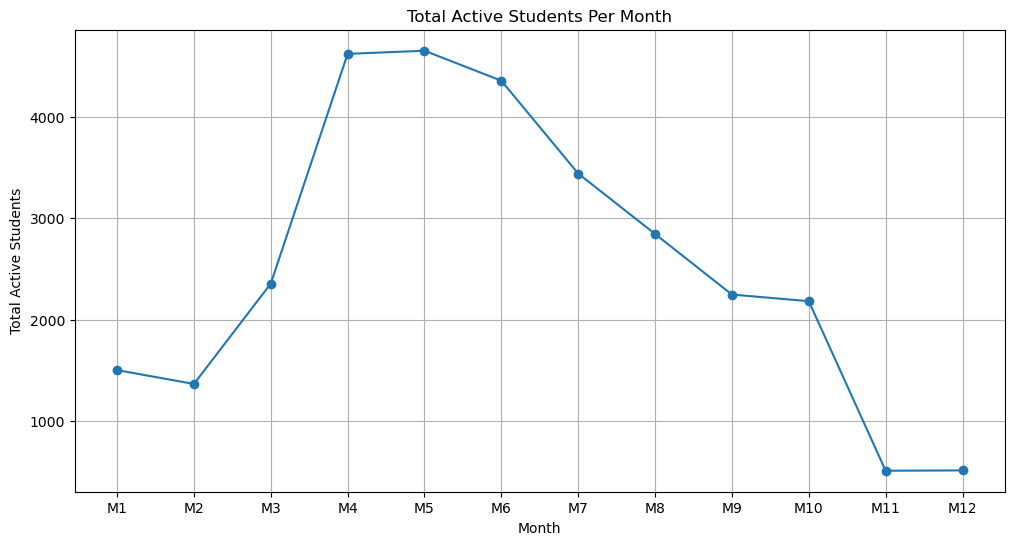

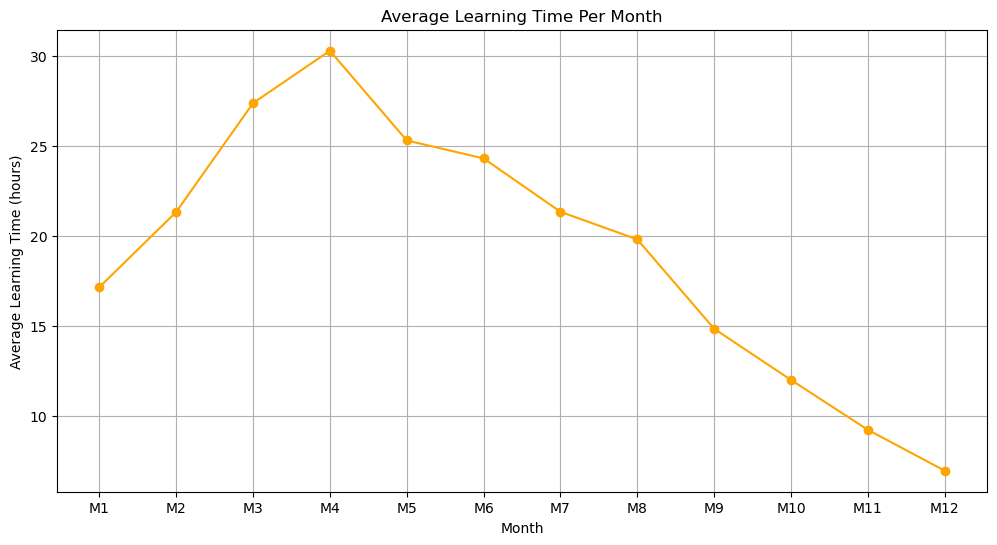

In [37]:
# Call the function to plot total active students
plot_total_active_students(trends_basic_stats_1)

# Call the function to plot average learning time
plot_average_learning_time(trends_basic_stats_1)

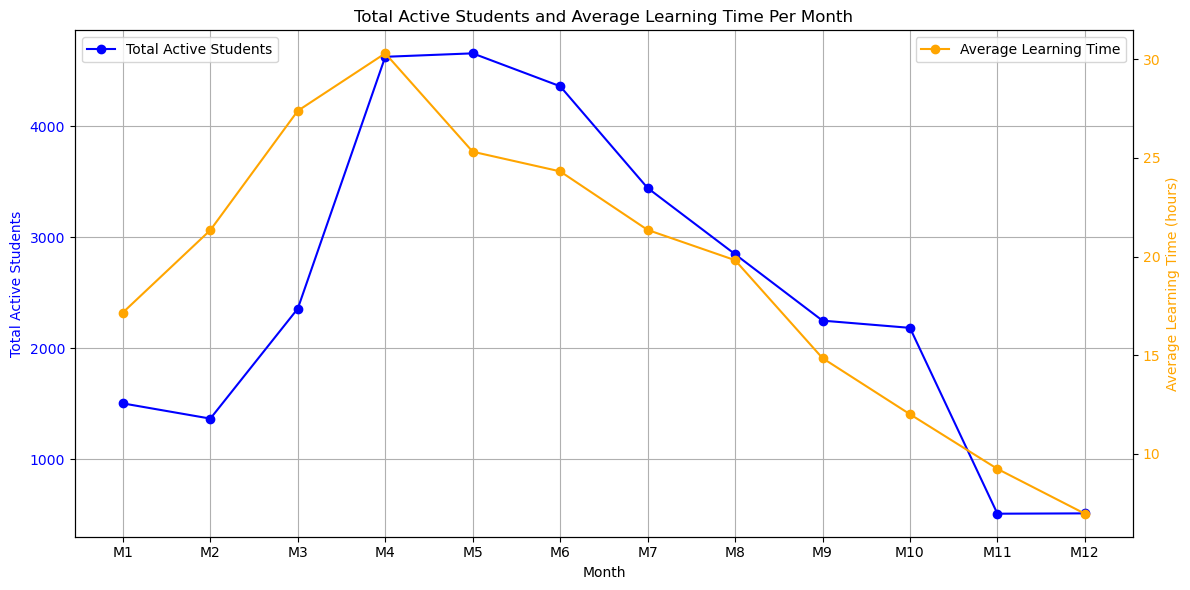

In [42]:
# Creating a superimposed plot of the two plots (plot_total_active_students, plot_average_learning_time) to see them together

def plot_superimposed_trends(df):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plotting the total active students on the primary y-axis
    ax1.plot(df['Month'], df['Total Active Students'], marker='o', label='Total Active Students', color='blue')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total Active Students', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    # Creating a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(df['Month'], df['Average Learning Time'], marker='o', label='Average Learning Time', color='orange')
    ax2.set_ylabel('Average Learning Time (hours)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title('Total Active Students and Average Learning Time Per Month')

    # Need a legend now
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()
    
plot_superimposed_trends(trends_basic_stats_1)